In [2]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
%matplotlib inline
from tqdm import notebook
import tensorflow as tf
from scipy import stats
from scipy.interpolate import interp1d

### Read dt

In [3]:
dt=np.load('energydt.npy')

# the full design matrix
x=dt[:,:-1]
y=dt[:,-1].reshape(-1,1)
ntrain=int(np.floor(len(x)*0.6))
stats.describe(y)

DescribeResult(nobs=1441, minmax=(array([-2.20522073]), array([5.33367964])), mean=array([-0.00326602]), variance=array([0.98530207]), skewness=array([0.56837019]), kurtosis=array([1.30282701]))

### g-only, this is equivalent to using pre-training in under the Collaborating Network(CN) framework

In [4]:
def variables_from_scope(scope_name):
    """
    Returns a list of all trainable variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope_name)

In [5]:
 # Graph parameters
intermediate_layer_size = 100
intermediate_layer_size2 = 80
# Training parameters
batch_size = 128
pre_iter= 36000

In [6]:
# g function learn the cdf
def g(yq,x):
    """
    yq:quantile:,
    x:input feature and treatment,
    """
    z1=tf.concat([yq,x],axis=1)
    hidden_layer = tf.compat.v1.layers.dense(z1, intermediate_layer_size,kernel_initializer=tf.compat.v1.initializers.random_normal(stddev=.001), name="g1", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer_bn = tf.compat.v1.layers.batch_normalization(hidden_layer,name="g1bn")
    hidden_layer2 = tf.compat.v1.layers.dense(hidden_layer_bn, intermediate_layer_size2, kernel_initializer=tf.compat.v1.initializers.random_normal(stddev=.001),name="g2", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer2_bn = tf.compat.v1.layers.batch_normalization(hidden_layer2,name="g2bn")
    gq_logit = tf.compat.v1.layers.dense(hidden_layer2_bn, 1,kernel_initializer=tf.initializers.glorot_normal, name="g3", activation=None,reuse=None)
    gq_logit_bn=tf.keras.layers.BatchNormalization(axis=-1,momentum=.1)(gq_logit)
    return gq_logit_bn

In [7]:
tf.compat.v1.disable_eager_execution()

In [8]:

tf.compat.v1.reset_default_graph()

# Placeholders
y_ = tf.compat.v1.placeholder(tf.float32, [None, 1])

pre_y= tf.compat.v1.placeholder(tf.float32, [None, 1])
x_=tf.compat.v1.placeholder(tf.float32, [None, x.shape[1]])
q_ = tf.compat.v1.placeholder(tf.float32, [None, 1])


ylessthan_pre= tf.cast(tf.less_equal(y_,pre_y),tf.float32)


with tf.compat.v1.variable_scope("g") as scope:
    gq_logit_pre = g(pre_y,x_)
    gq=tf.sigmoid(gq_logit_pre)




#pre-loss
g_loss_pre = tf.compat.v1.losses.sigmoid_cross_entropy(ylessthan_pre,gq_logit_pre)

# Optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)
pre_step= optimizer.minimize(g_loss_pre,var_list=variables_from_scope("g"))


# Initializer
initialize_all = tf.compat.v1.global_variables_initializer()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


### Ten replications to evaluate the hard metrics

In [11]:
##function to create replication
def rep_iter(x,y,frac=0.4):
    n=len(x)
    ntest=int(np.floor(frac*n))
    allidx=np.random.permutation(n)
    trainidx= allidx[ntest:]
    testidx= allidx[:ntest]
    return x[trainidx],y[trainidx],x[testidx],y[testidx]
    

In [12]:
#initialize the metric
#g
gll=[] #loglikelihood or gof
gcal=[] #regular calibration
gcalshp=[] #empirical coverage
gwidth=[] #empirical width
g90=[] #90 interval coverage
gmae=[] #mae



In [13]:
np.random.seed(2021)
for a in range(10):
    train_x,train_y,test_x,test_y=rep_iter(x,y)
    ntrain=len(train_x)
    ntest=len(test_x)

    

    sess = tf.compat.v1.Session()
    sess.run(initialize_all)
    gl=[]
    fl=[]


    sess = tf.compat.v1.Session()
    sess.run(initialize_all)
    gl=[]
    
    sess = tf.compat.v1.Session()
    sess.run(initialize_all)
    glpre=[]


    for k in notebook.tnrange(pre_iter):
        i=np.random.choice(ntrain,batch_size,replace=False)
        ytmp = train_y[i,:]
        xtmp= train_x[i,:]
        #when we do not have f initially, we use a uniform distribution to extract points from support
        pre_ytmp=np.random.uniform(-2.5,6,(batch_size,1))  
        ltmp,_=sess.run([g_loss_pre,pre_step],feed_dict={y_: ytmp,
                                    x_:xtmp,
                                    pre_y:pre_ytmp})

        glpre.append(ltmp)


    #####calculate metrics##############

    per=np.linspace(0.02,0.98,8) #quantile to study calibration
    pershp=np.linspace(0.4,0.999,20) #nominal quantile to study sharpness


    #lower and upper bound
    low=np.quantile(test_y,0.05)
    high=np.quantile(test_y,0.95)
    itv=np.linspace(low,high,9)
    itv=np.append(-np.infty,itv)
    itv=np.append(itv,np.infty)
    #outcome1 belongs to which interval
    id=np.zeros(ntest)
    for i in range(10):
        id=id+1*(test_y.ravel()>itv[i+1])
    id=id.astype('int')


    # estimation by g
    med_est=np.array([])
    ll_est=np.empty(ntest)
    cal_est=np.zeros_like(per)
    cal_shp=np.zeros_like(pershp)
    cal_width=[]
    cover_90=0


    #use interpolation to recover cdf
    xtmp=np.linspace(-2.5,6,5000)

    for i in range(ntest):
        l=itv[id[i]]
        r=itv[id[i]+1]

        #cdf estimate by g
        cdf=sess.run(gq ,feed_dict={x_:np.tile(test_x[i,:],(5000,1)),
                                    pre_y:xtmp[:,None]
                                    }).ravel()

        cdf[0]=0
        cdf[-1]=1
        invcdfest=interp1d(cdf,xtmp)
        cdfest=interp1d(xtmp,cdf)


        #estimate the mae
        med_est=np.append(med_est,invcdfest(0.5))    


        #estimate the loglikelihood
        l=itv[id[i]]
        r=itv[id[i]+1]
        if(r==np.inf):
            ll_est[i]=np.log(1.-cdfest(l)+1.e-10)
        elif(l==-np.inf):
            ll_est[i]=np.log(cdfest(r)+1.e-10)
        else:
            ll_est[i]=np.log(cdfest(r)-cdfest(l)+1.e-10)


        #estimate the calibration
        cal_est=cal_est+1.*(test_y[i]<invcdfest(0.5+per/2))*(test_y[i]>invcdfest(0.5-per/2))

        #estimate the quantity for sharpness
        gl=invcdfest(0.5-pershp/2)
        gr=invcdfest(0.5+pershp/2)
        
        
        cal_shp=cal_shp+1.*(test_y[i]<gr)*(test_y[i]>gl)
        cal_width.append(gr-gl)
        
        
        #estimate 90 coverage
        r=invcdfest(0.95)
        l=invcdfest(0.05)
        cover_90+=(test_y[i]<r)*(test_y[i]>l)

    

    #summary    

    cal_est=cal_est/ntest
    cal_shp=cal_shp/ntest


    #cal
    gcal.append(cal_est)

    #shp
    gcalshp.append(cal_shp)
    gwidth.append(np.median(np.array(cal_width),0))
    
    
    #ll
    gll.append(ll_est.mean())

    #90coverage
    g90.append(cover_90/ntest)

    #mae
    gmae.append(np.abs(test_y.ravel()-med_est).mean()) #regular mae
    

In [14]:
def musd(x):
    print(np.mean(x),np.std(x))



In [15]:

musd(gll)
musd(g90)
musd(gmae)



-1.7963343089916086 0.035666254818202396
0.8895833333333334 0.0174856643222419
0.530843750333898 0.013750446902867435


In [16]:
#calibration
def calcompu(x):
    x=np.array(x)
    n=len(x)
    cal=np.mean(x,0)
    calest=np.abs(x-per).mean(1)
    
    print(np.mean(calest),np.std(calest))
    
    return  cal

gcalplot=calcompu(gcal)

0.02009536210317462 0.00907661568696799


In [17]:
def shpplt(cal,width): #average interval width calculation
    n=len(cal)
    cal=np.array(cal)
    width=np.array(width)
    low=np.max(cal[:,0])
    up=np.min(cal[:,-1])
    rangeint=np.linspace(low,up,30)
    widest=[]
    for i in range(n):
        widest.append(interp1d(cal[i],width[i])(rangeint))
    
    return rangeint,np.array(widest).mean(0)
    

In [18]:
gempcal,gempwid=shpplt(gcalshp,gwidth)

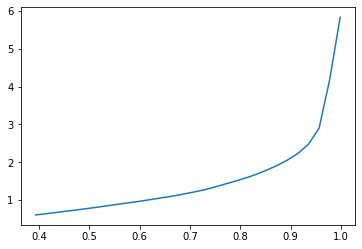

In [19]:
plt.plot(gempcal,gempwid)